In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import cv2
import seaborn as sns
import rasterio.features
import rasterio.transform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from utils import get_dataset, prepare_data, process_single_fire, scale_numerical_data

In [3]:
df = get_dataset("../data/dataset.csv")

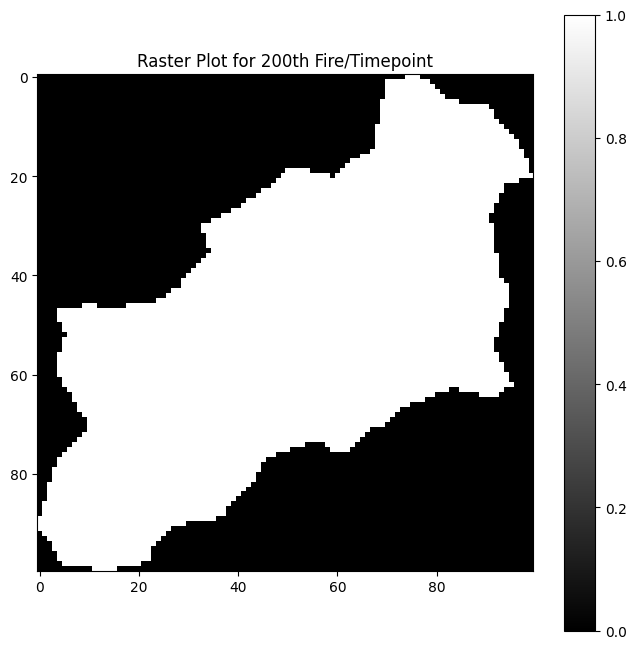

In [4]:
plt.figure(figsize=(8, 8))
plt.imshow(df.raster[200], cmap='gray')
plt.colorbar()
plt.title('Raster Plot for 200th Fire/Timepoint')
plt.show()

In [5]:
s = df[df.FIRE_NAME == "FLAT"]
X, y = process_single_fire(s)
print(X)
print(y)

[[array([0, 0, 0, ..., 0, 0, 0]), np.float64(54.0), np.float64(1.08), np.float64(0.95), np.float64(6.5), np.float64(7.770000000000001e-08), np.float64(250.99), np.float64(0.027), np.float64(0.29)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(59.0), np.float64(1.15), np.float64(0.94), np.float64(7.2), np.float64(8.030000000000001e-08), np.float64(250.97), np.float64(0.0258), np.float64(0.36)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(60.0), np.float64(1.14), np.float64(0.9200000000000002), np.float64(5.990000000000001), np.float64(7.500000000000001e-08), np.float64(250.85), np.float64(0.0254), np.float64(0.36)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(66.0), np.float64(1.25), np.float64(0.91), np.float64(6.48), np.float64(7.920000000000002e-08), np.float64(250.89), np.float64(0.0253), np.float64(0.45)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(57.0), np.float64(1.0), np.float64(0.9), np.float64(6.260000000000001), np.float64(6.260000000000003e-08), np.float64(250.55), np.float

In [ ]:
X, y = prepare_data(df)
X_scaled = scale_numerical_data(X)

In [ ]:
def expand_array_elements(data):
    """
    This function takes a list of sublists where each sublist starts with a numpy array.
    """
    for i in range(len(data)):
        # Convert the numpy array (first element) to a list and extend the sublist with its elements
        array_elements = data[i][0].tolist()  # Convert the np.array to a list
        data[i] = array_elements + data[i][1:]  # Merge
        
    return data

In [13]:
X_scaled = np.array(expand_array_elements(X_scaled))
y_scaled = np.array(y)

In [16]:
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_scaled.shape

(5427, 1, 10008)

In [17]:
# LSTM model Arch
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2]), return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dense(100*100))  # Output the flattened raster (10000) - need to convert back to 2D later

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

c:\Users\Nathan\anaconda3\envs\ecs171project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.fit(X_scaled[:6], y_scaled[:6], epochs=50, batch_size=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4452
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1485
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1220
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0936
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1064
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0825
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0741
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0776
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0703
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0604
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0620
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0498
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0496
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0453
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0505
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━

In [26]:
prediction = model.predict(X_scaled[5].reshape(1, X_scaled.shape[1], X_scaled.shape[2]))
prediction = prediction.reshape((100, 100))
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[-7.78010162e-03, -1.56110991e-03,  4.47511114e-02, ...,
        -2.30225064e-02,  4.18171138e-02, -2.19473355e-02],
       [ 3.56407762e-02,  5.42066526e-03,  1.10998929e-01, ...,
        -1.61684416e-02, -6.63951319e-03, -3.30336802e-02],
       [ 1.14724366e-03,  7.73059949e-03, -3.82581237e-03, ...,
         1.60909276e-02,  1.30340746e-02,  2.00948417e-02],
       ...,
       [ 2.41413526e-02, -1.84005145e-02, -4.34417324e-03, ...,
        -4.52532247e-03,  1.05349272e-01,  1.12438202e-03],
       [ 1.06971115e-02, -1.32661462e-01, -1.10167628e-02, ...,
        -2.17570867e-02,  1.04915798e-02, -1.73841044e-02],
       [ 8.45840201e-03,  9.15890560e-05,  1.74162462e-02, ...,
        -1.70957309e-03, -3.22531052e-02,  1.62632745e-02]], dtype=float32)

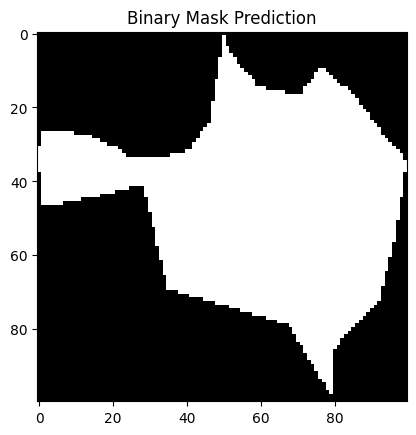

In [28]:
binary_mask = (prediction > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask Prediction')
plt.show()